# Spot the difference

Some python code to compare two images pixel by pixel. <br>
We will use the **Structural Similarity Index (SSIM)** to spot the difference between two images

In this notebook you will:

- Visualize two images you want to compare
- Run a spot the difference function to compute images similarity and the number of detected differences
- Visualize the differences of the images (filled image, mask image)

Serge Retkowsky | serge.retkowsky@microsoft.com | V1 22-July-2022

In [1]:
import numpy as np
import cv2
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import Image
from skimage.metrics import structural_similarity
%matplotlib inline

In [2]:
print("Today:", datetime.now())

Today: 2022-07-22 14:52:13.002327


In [3]:
import sys
print("Python version:", sys.version)

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [4]:
RES_DIR = 'outputs'

if not os.path.exists(RES_DIR):  # Only if dir not exist
    print("Dir:", RES_DIR, "does not exist.")
    print("So let's create dir:", RES_DIR)
    os.mkdir(RES_DIR)
    print("Done")

else:
    print("Dir:", RES_DIR, "exist. So let's use it.")

Dir: outputs exist. So let's use it.


## Python functions definitions

In [5]:
def check_image(image1, image2):
    # To check if images exist
    from os.path import exists
    
    if exists(image1) and exists(image2):
        print("Files are available. Images should have the same shape")
        img1 = cv2.imread(image1)
        img2 = cv2.imread(image2)
        print("Image file 1:", image1, " shape =", img1.shape)
        print("Image file 2:", image2, " shape =", img2.shape)
        
    else:
        print("Error!")
        if not exists(image1):
            print(image1, ' is not available')
        if not exists(image2):
            print(image2, ' is not available')

In [6]:
def side_by_side_images(image1, image2, w, h):
    # To display the two images side by side
    img1 = plt.imread(image1)
    img2 = plt.imread(image2)
    f, ax = plt.subplots(1, 2, figsize=(w, h))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[0].set_title("Image1:" + image1)
    ax[1].set_title("Image2:" + image2)

    title = 'Spot the difference between these two images.'

    f.suptitle(title, fontsize=18)
    plt.tight_layout()
    
    plt.savefig(RES_DIR + "/" + os.path.basename(image1).split('.')[0] + "_bothimages.jpg")
    plt.show()

In [7]:
def spot_the_difference(image1, image2, minvalue):
    # To spot the difference between the two images
    
    # Settings
    green_color = (0, 255, 0)
    red_color = (0, 0, 255)
    cyan_color = (255, 255, 0)

    rect_color = red_color
    rect_size = 3
    txt_color = red_color
    txt_size = 6

    contour_color1 = green_color
    contour_color2 = cyan_color

    offset = 40

    # Loading images using OpencV
    img1 = cv2.imread(image1)
    img2 = cv2.imread(image2)

    print("Comparing images:", imagefile1, "and", imagefile2)

    # Switch to gray
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Computation of the structural similarity index
    (score, diff) = structural_similarity(img1_gray, img2_gray, full=True)

    print("\n\033[1;31;34mImage Similarity: {:.5f}%".format(score * 100))
    print("Image Difference: {:.5f}%".format(100 - score * 100))
    print('\033[0m')
    
    diff = (diff * 255).astype("uint8")
    diff_boxes = cv2.merge([diff, diff, diff])
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # Contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # Initial Mask image
    mask = np.zeros(img1.shape, dtype='uint8')
    filled_img = img2.copy()

    nb_differences = 0

    for c in contours:
        area = cv2.contourArea(c)
    
        if area > minvalue:
            txt = str(nb_differences + 1)
            x, y, w, h = cv2.boundingRect(c)
            
            # Adding rectangles, text and contours
            cv2.rectangle(img1, (x, y), (x + w, y + h), rect_color, rect_size)
            
            cv2.rectangle(img2, (x, y), (x + w, y + h), rect_color, rect_size)
            cv2.putText(img2, txt, (x, y + h + offset), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, txt_color, txt_size)
            
            cv2.drawContours(mask, [c], 0, contour_color1, -1)
            cv2.putText(mask, txt, (x, y + h + offset), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, txt_color, txt_size)
        
            cv2.drawContours(filled_img, [c], 0, contour_color2, -1)
            cv2.putText(filled_img, txt, (x, y + h + offset), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, txt_color, txt_size)
        
            # Saving images
            basename = os.path.basename(imagefile1).split('.')[0]
            image1 = RES_DIR + "/" + basename + "_image1.jpg"
            image2 = RES_DIR + "/" + basename + "_image2.jpg"
            maskimage = RES_DIR + "/" + basename + "_mask.jpg"
            filled_image = RES_DIR + "/" + basename + "_filled_img.jpg"

            cv2.imwrite(image1, img1)
            cv2.imwrite(image2, img2)
            cv2.imwrite(maskimage, mask)
            cv2.imwrite(filled_image, filled_img)
        
            nb_differences += 1
        
    print("\033[1;31;91m==> Number of differences =", nb_differences, '\033[0m')

    return image1, image2, maskimage, filled_image, nb_differences, score

In [8]:
def viewing_images(w, h):
    # To display the 4 images results
    
    print(datetime.now(), " Comparing image:", image1, "with", image2)
    print("\n", "-" * 50, "Results", "-" * 50, "\n")
    print("\033[1;31;91mNumber of differences =", nb_differences, "| similarity index =", score, '\033[0m')

    fig = plt.figure(figsize=(w, h))
    rows = columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(image1), cv2.COLOR_BGR2RGB))
    plt.title("Initial image")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(cv2.cvtColor(cv2.imread(image2), cv2.COLOR_BGR2RGB))
    plt.title("Second image")

    fig.add_subplot(rows, columns, 3)
    plt.imshow(cv2.cvtColor(cv2.imread(filled_image), cv2.COLOR_BGR2RGB))
    plt.title("Filled Image")

    fig.add_subplot(rows, columns, 4)
    plt.imshow(cv2.cvtColor(cv2.imread(maskimage), cv2.COLOR_BGR2RGB))
    plt.title("Mask Image")
    
    plt.savefig(RES_DIR + "/" + os.path.basename(imagefile1).split('.')[0] + "_all.jpg")

## 1. Example 1

In [9]:
imagefile1 = 'ID1.jpg'
imagefile2 = 'ID2.jpg'
check_image(imagefile1, imagefile2)

Files are available. Images should have the same shape
Image file 1: ID1.jpg  shape = (738, 1040, 3)
Image file 2: ID2.jpg  shape = (738, 1040, 3)


In [10]:
image1, image2, maskimage, filled_image, nb_differences, score = spot_the_difference(imagefile1, imagefile2, 50)

Comparing images: ID1.jpg and ID2.jpg

Image Similarity: 99.38827%
Image Difference: 0.61173%

==> Number of differences = 12 


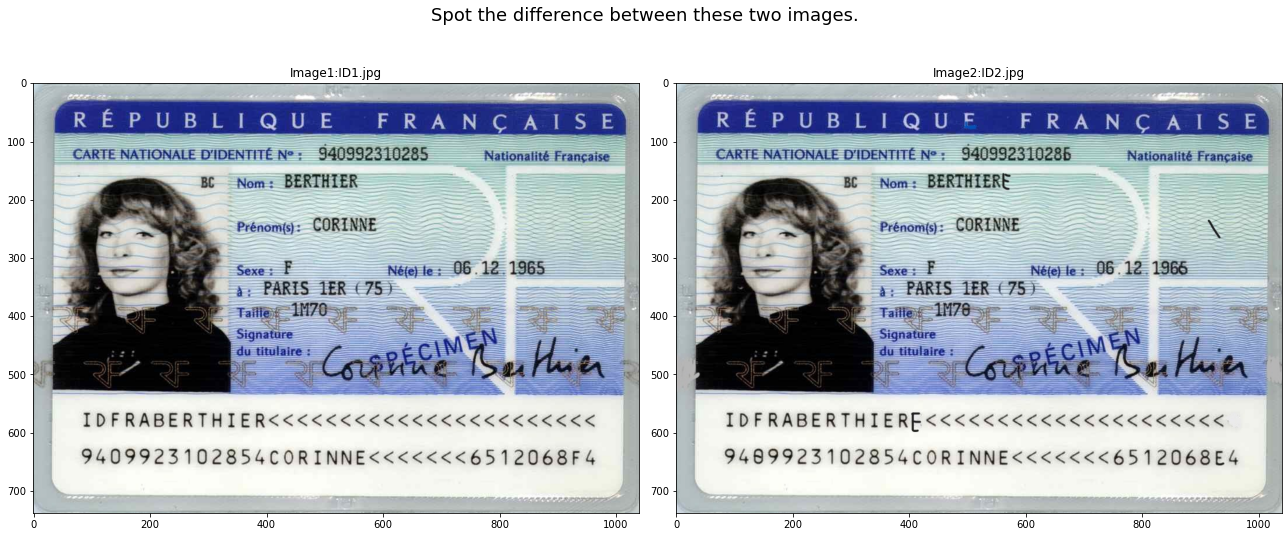

In [11]:
side_by_side_images(imagefile1, imagefile2, 18, 8)

2022-07-22 14:52:47.527197  Comparing image: outputs/ID1_image1.jpg with outputs/ID1_image2.jpg

 -------------------------------------------------- Results -------------------------------------------------- 

Number of differences = 12 | similarity index = 0.9938826612546015 


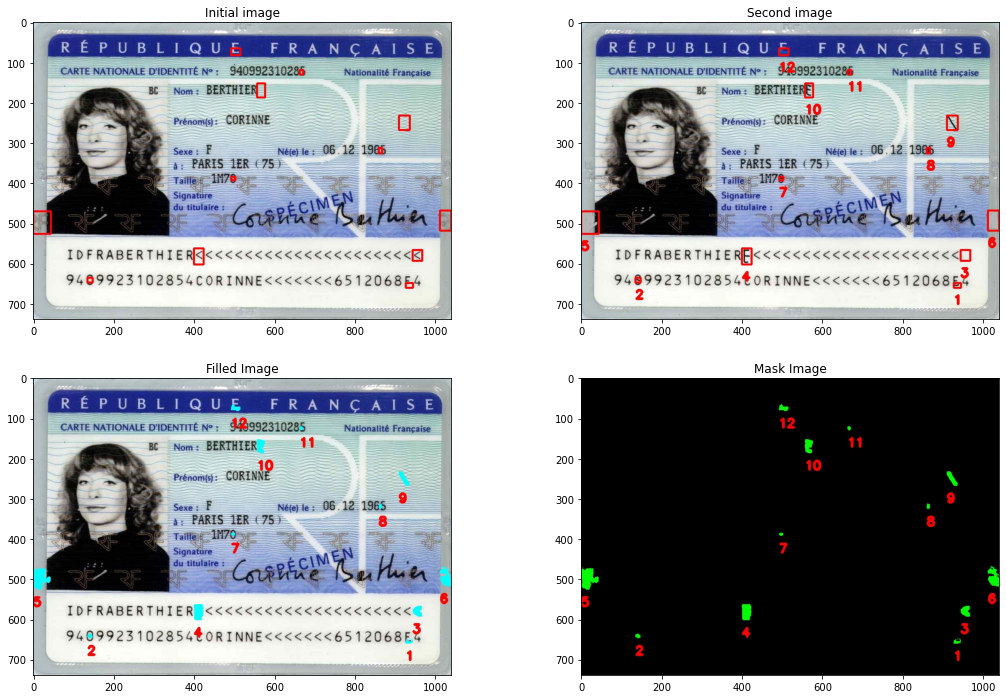

In [12]:
viewing_images(18, 12)

## 2. Example 2

In [13]:
imagefile1 = 'food1.jpg'
imagefile2 = 'food2.jpg'
check_image(imagefile1, imagefile2)

Files are available. Images should have the same shape
Image file 1: food1.jpg  shape = (667, 500, 3)
Image file 2: food2.jpg  shape = (667, 500, 3)


In [14]:
image1, image2, maskimage, filled_image, nb_differences, score = spot_the_difference(imagefile1, imagefile2, 60)

Comparing images: food1.jpg and food2.jpg

Image Similarity: 91.98863%
Image Difference: 8.01137%

==> Number of differences = 6 


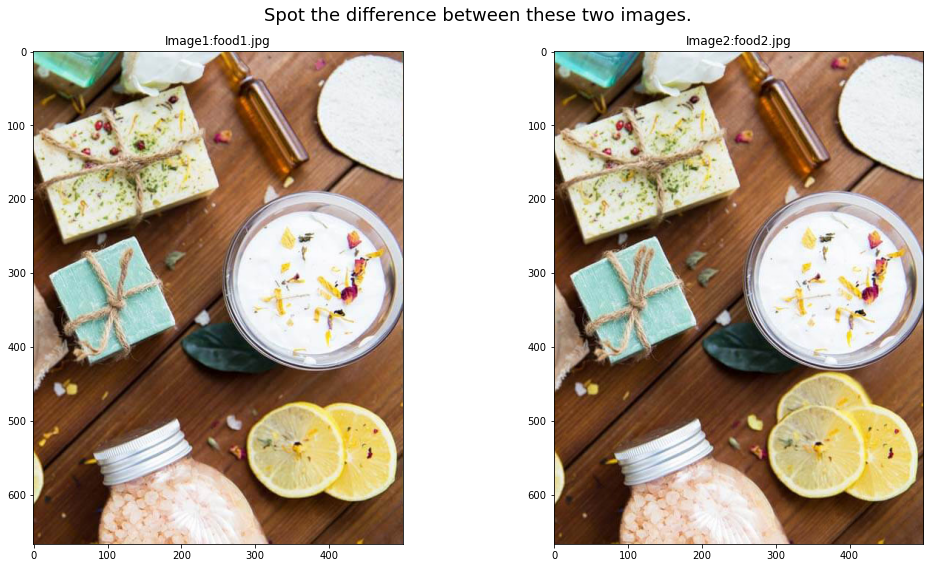

In [15]:
side_by_side_images(imagefile1, imagefile2, 15, 8)

2022-07-22 14:52:58.925031  Comparing image: outputs/food1_image1.jpg with outputs/food1_image2.jpg

 -------------------------------------------------- Results -------------------------------------------------- 

Number of differences = 6 | similarity index = 0.9198863419190031 


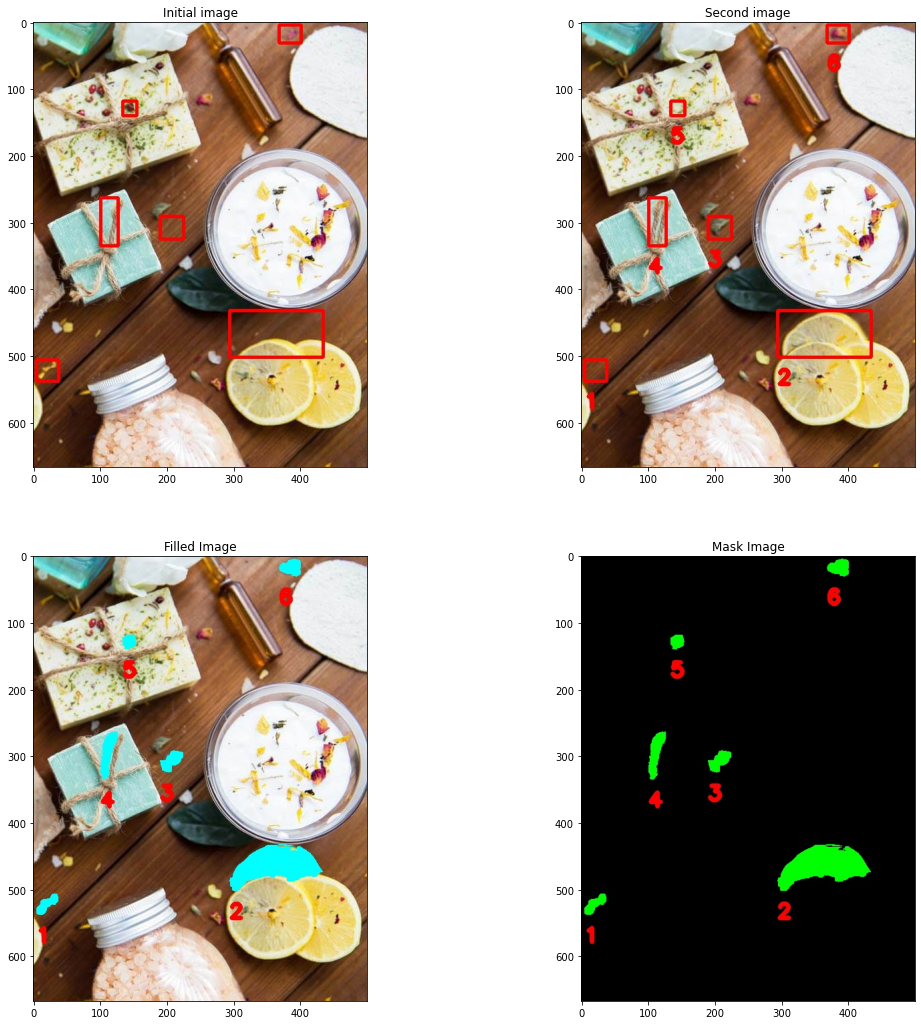

In [16]:
viewing_images(18, 18)

## 3. Example 3

In [17]:
imagefile1 = 'document1.jpg'
imagefile2 = 'document2.jpg'
check_image(imagefile1, imagefile2)

Files are available. Images should have the same shape
Image file 1: document1.jpg  shape = (1170, 850, 3)
Image file 2: document2.jpg  shape = (1170, 850, 3)


In [18]:
image1, image2, maskimage, filled_image, nb_differences, score = spot_the_difference(imagefile1, imagefile2, 60)

Comparing images: document1.jpg and document2.jpg

Image Similarity: 99.23081%
Image Difference: 0.76919%

==> Number of differences = 7 


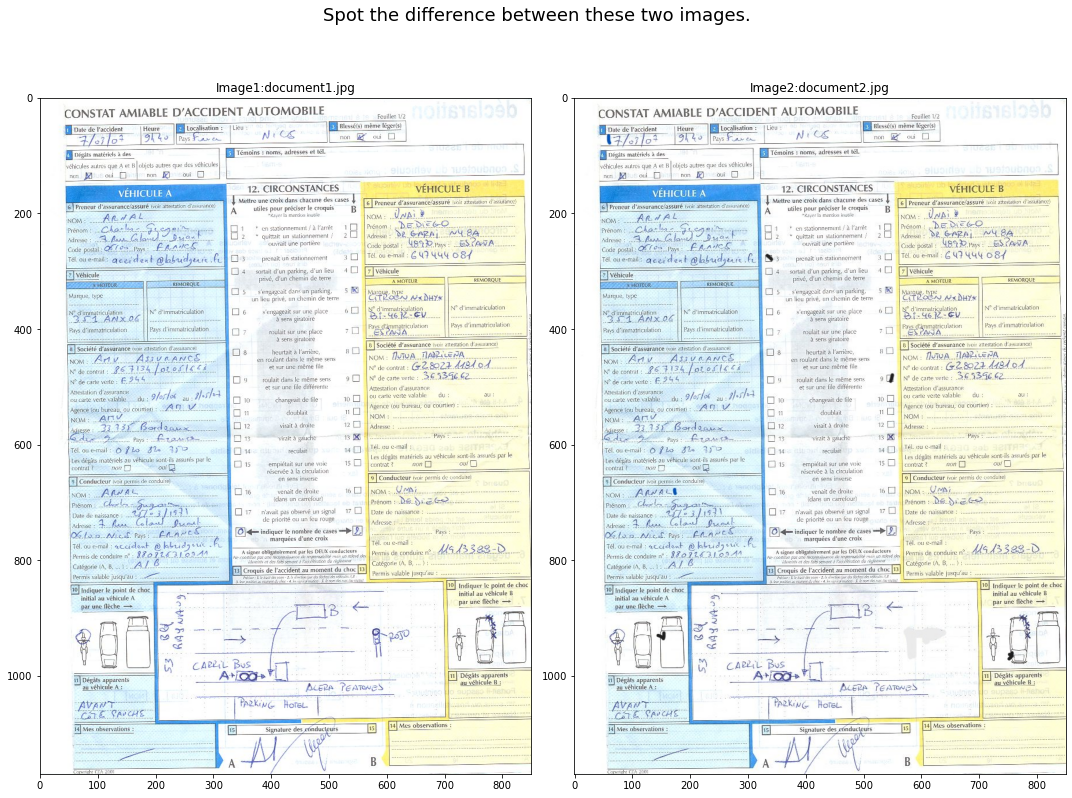

In [19]:
side_by_side_images(imagefile1, imagefile2, 15, 12)

2022-07-22 14:53:11.405173  Comparing image: outputs/document1_image1.jpg with outputs/document1_image2.jpg

 -------------------------------------------------- Results -------------------------------------------------- 

Number of differences = 7 | similarity index = 0.9923081374950058 


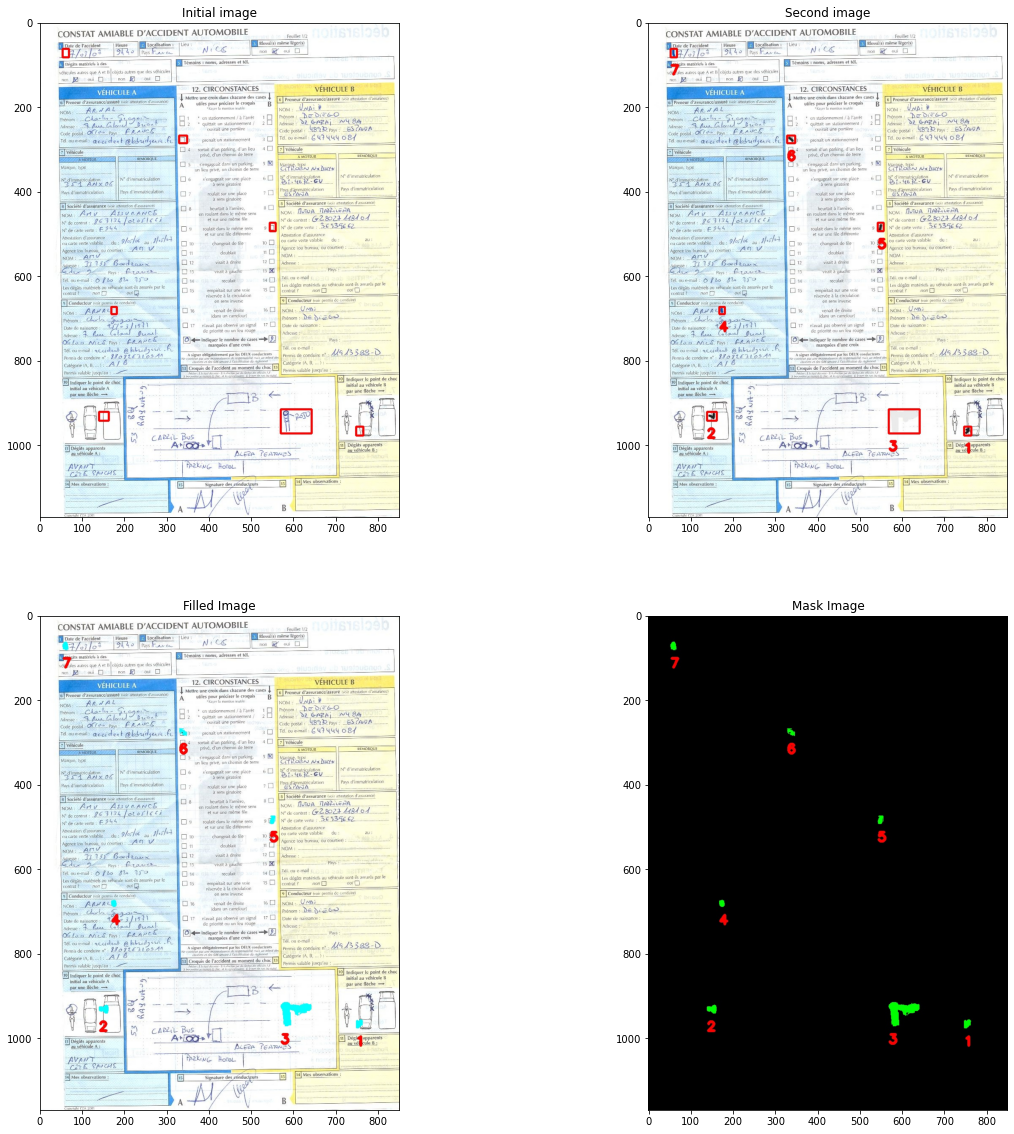

In [20]:
viewing_images(20, 20)

## 4. Example 4

In [21]:
imagefile1 = 'store1.jpg'
imagefile2 = 'store2.jpg'
check_image(imagefile1, imagefile2)

Files are available. Images should have the same shape
Image file 1: store1.jpg  shape = (563, 750, 3)
Image file 2: store2.jpg  shape = (563, 750, 3)


In [22]:
image1, image2, maskimage, filled_image, nb_differences, score = spot_the_difference(imagefile1, imagefile2, 60)

Comparing images: store1.jpg and store2.jpg

Image Similarity: 98.74238%
Image Difference: 1.25762%

==> Number of differences = 4 


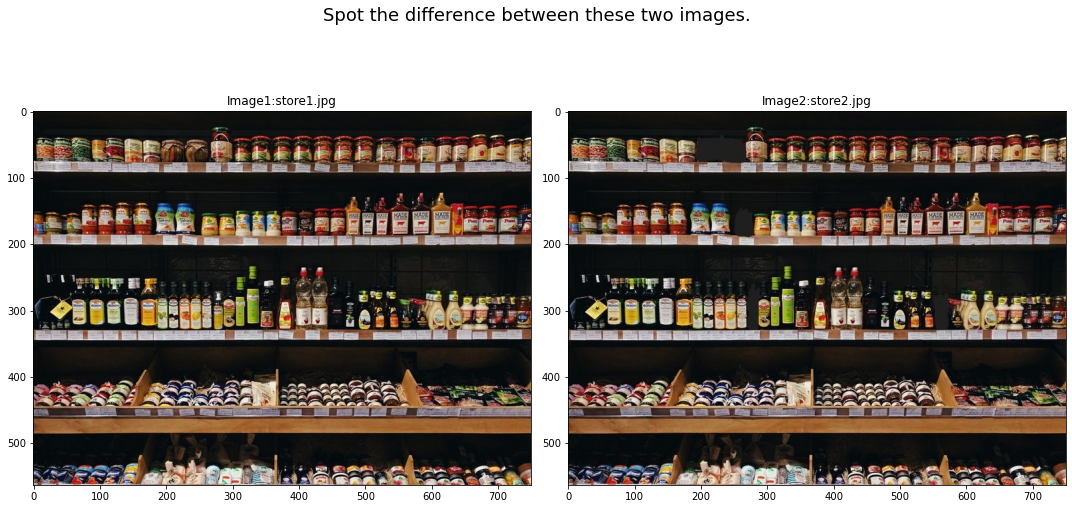

In [23]:
side_by_side_images(imagefile1, imagefile2, 15, 8)

2022-07-22 14:53:22.435699  Comparing image: outputs/store1_image1.jpg with outputs/store1_image2.jpg

 -------------------------------------------------- Results -------------------------------------------------- 

Number of differences = 4 | similarity index = 0.9874237567745341 


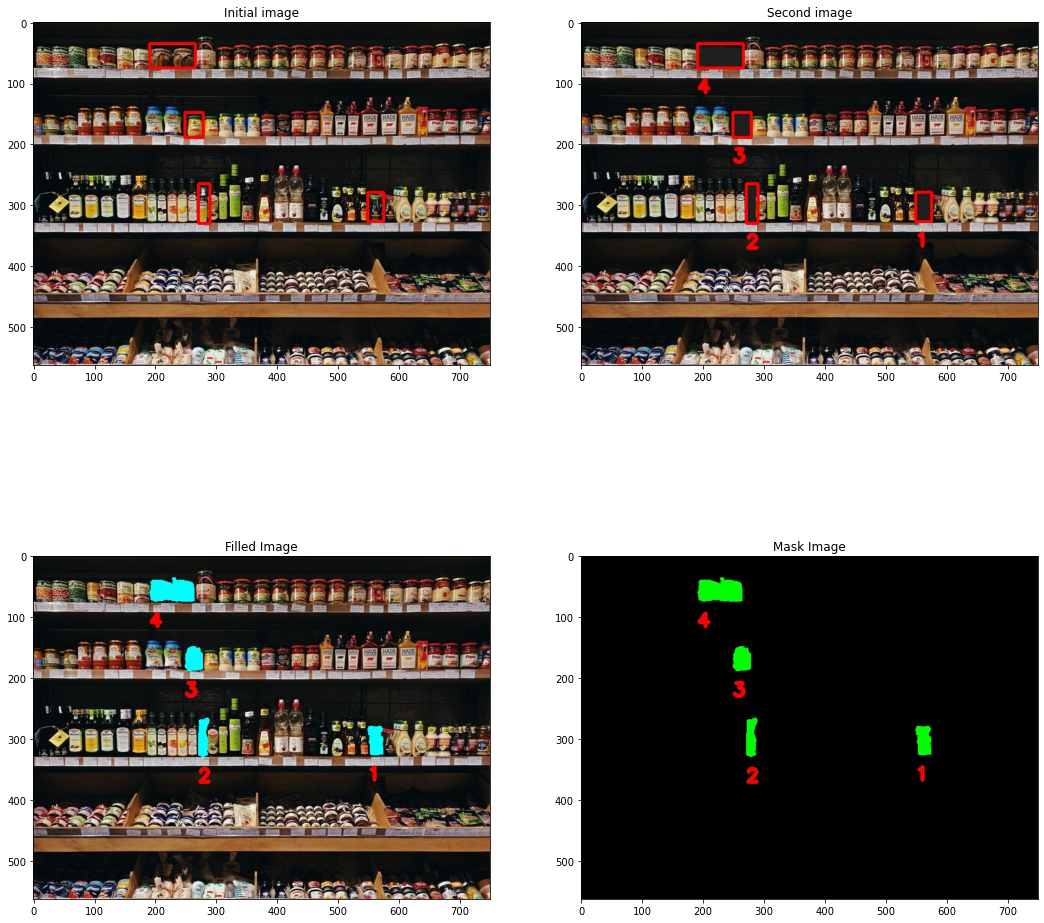

In [24]:
viewing_images(18, 18)

> End